# Boosting Basic Concepts

## What does boosting try to accomplish?

## To make a better classifier how do we pick the next classifier?

# AdaBoost - Concepts

## Exponential Loss

Exponential loss is given by

$$
exp\; loss = \sum_i exp(-y^{(i)} guess^{(i)})
$$

convince yourself that this make sense.

## Write down the form of the boosted classifier.

## How do we select the next classifier to add to our boosted classifier

## How do we find the weight?

# AdaBoost - Practical

You are given a bunch of perceptron classifier(aka the output is determined by which side of the line the data is on)

Each of the classifier doesn't do too well. We want to build the adaboost classifier to classify this moon data.

In [1]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import numpy as np

In [2]:
np.random.seed(333)
xs, ys = make_moons(n_samples=500, noise=0.3)
ys[ys==0] = -1

def plot_data(xs, ys):
    plt.plot(xs[:,0][ys>0], xs[:,1][ys>0], '.b')
    plt.plot(xs[:,0][ys<0], xs[:,1][ys<0], '.r')

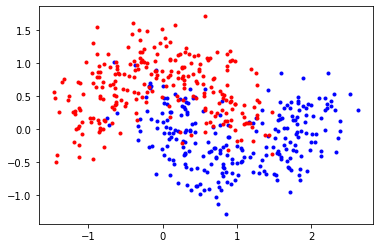

In [3]:
plot_data(xs ,ys)

In [4]:
class Perceptron:
    def __init__(self, cx, cy, angle):
        self.cx = cx
        self.cy = cy
        self.angle = angle
    
    def classify_single(self, x1, x2):
        return 1. if (x1-self.cx)*np.cos(self.angle) + (x2-self.cy)*np.sin(self.angle) > 0 else -1.
    
    def classify(self, xs):
        shift_x = xs[:, 0] - self.cx
        shift_y = xs[:, 1] - self.cy
        
        dot = shift_x*np.cos(self.angle) + shift_y*np.sin(self.angle)
        tmp = np.zeros_like(dot, dtype=float)
        tmp[dot>0] = 1.
        tmp[dot<=0] = -1.
        return tmp
    
    def line(self, tmin=-1, tmax=1):
        ts = np.linspace(tmin, tmax, 100)
        xs = self.cx + ts*np.cos(self.angle+np.pi/2)
        ys = self.cy + ts*np.sin(self.angle+np.pi/2)
        return xs, ys
    
    def plot_line(self):
        lxs, lys = self.line()
        plt.plot(lxs, lys)
    
    def exp_loss(self, xs, ys):
        got = self.classify(xs)
        return np.sum(np.exp(-ys*got))
        
    def __repr__(self):
        return f'Perceptron(cx={self.cx:.2f}, cy={self.cy:.2f}, angle={self.angle:.2f})'

def random_classifier():
    cx = np.random.random()*5 - 2.5
    cy = np.random.random()*3 - 1.5
    angle = np.random.random()*2*np.pi
    return Perceptron(cx = cx, cy=cy, angle=angle)

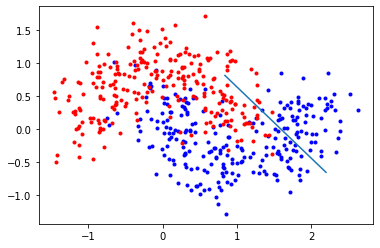

In [5]:
np.random.seed(999)
clf = random_classifier()
plot_data(xs, ys)
clf.plot_line()

Perceptron(cx=1.52, cy=0.08, angle=0.75)

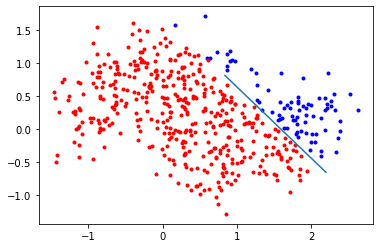

In [6]:
guess = clf.classify(xs)
plot_data(xs, guess)
clf.plot_line()
clf

In [7]:
#fill this up

class ADABoost:
    def __init__(self, alphas, classifiers):
        self.alphas = alphas
        self.classifiers = classifiers
    
    def classify_single(self, x1, x2):
        #fill this
        pass
    
    def classify(self, xs):
        pass
    
    @classmethod
    def empty(cls):
        return ADABoost([], [])
    
    @classmethod
    def build_ada(cls, xs, ys, classifiers, n=10):
        pass
    